### OpenCV Darknet Yolo를 이용하여 이미지와 영상 Object Detection
* yolo와 tiny-yolo 를 이용하여 Object Detection

# 아래는 OpenCV 실습 예제이므로 GPU가 필요하지 않으며 코랩 커널을 GPU로 바꿀 필요가 없습니다. 
OpenCV는 Colab에서 이미 설치 되어 있으니 추가설치는 필요 없습니다.

강의 실습코드와 데이터는 https://github.com/chulminkw/DLCV.git 에서 다운로드 할 수 있습니다. 

In [10]:
# 현재 디렉토리는 /content이며 이 디렉토리를 기준으로 실습코드와 데이터를 다운로드 합니다. 
!pwd
!rm -rf DLCV
!git clone https://github.com/chulminkw/DLCV.git
# DLCV 디렉토리가 Download되고 DLCV 밑에 Detection과 Segmentation 디렉토리가 있는 것을 확인
!ls -lia 
!ls -lia DLCV

/content/DLCV
Cloning into 'DLCV'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 145 (delta 17), reused 0 (delta 0), pack-reused 89
Receiving objects: 100% (145/145), 127.44 MiB | 39.92 MiB/s, done.
Resolving deltas: 100% (38/38), done.
total 164
2621494 drwxr-xr-x 7 root root   4096 Jul 31 09:38 .
4194310 drwxr-xr-x 1 root root   4096 Jul 31 08:45 ..
2621571 drwxr-xr-x 6 root root   4096 Jul 31 08:45 data
2621537 drwxr-xr-x 8 root root   4096 Jul 31 08:45 Detection
2621609 drwxr-xr-x 6 root root   4096 Jul 31 09:38 DLCV
2621522 -rw-r--r-- 1 root root 134412 Jul 31 08:45 DLCV_Colab_SrcCode.zip
2621495 drwxr-xr-x 8 root root   4096 Jul 31 08:45 .git
2621563 -rw-r--r-- 1 root root    142 Jul 31 08:45 README.md
2621564 drwxr-xr-x 3 root root   4096 Jul 31 08:45 Segmentation
total 160
2621609 drwxr-xr-x 6 root root   4096 Jul 31 09:38 .
2621494 drwxr-xr-x 7 root root   4096 Jul 31 09:38 

image shape: (633, 806, 3)


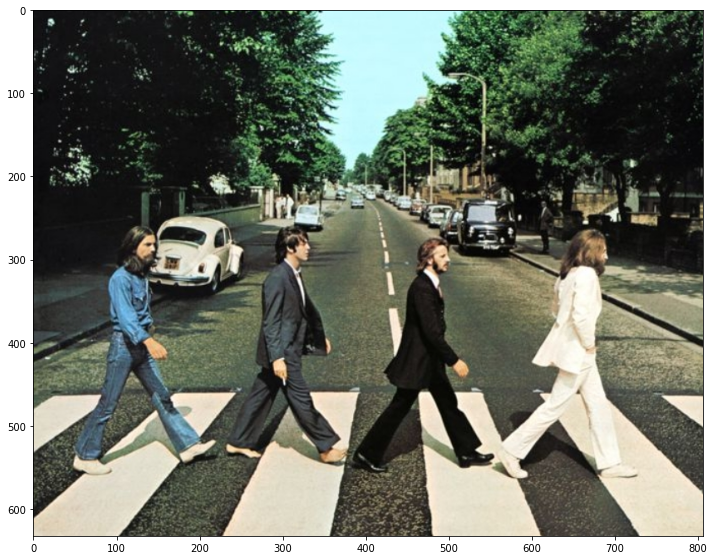

In [11]:
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

# 코랩 버전은 default_dir 은 /content/DLCV로 지정하고 os.path.join()으로 상세 파일/디렉토리를 지정합니다. 
default_dir = '/content/DLCV'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### Darknet Yolo사이트에서 coco로 학습된 Inference모델와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성

* https://pjreddie.com/darknet/yolo/ 에 다운로드 URL 있음.
* pretrained 모델은 wget https://pjreddie.com/media/files/yolov3.weights 에서 다운로드
* pretrained 모델을 위한 환경 파일은 https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg 에서 다운로드
* wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg
* readNetFromDarknet(config파일, weight파일)로 config파일 인자가 weight파일 인자보다 먼저 옴. 주의 필요. 

* tiny yolo의 pretrained된 weight파일은 wget https://pjreddie.com/media/files/yolov3-tiny.weights 에서 download 가능. 
* config 파일은 wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg 로 다운로드

### 코랩 버전은 아래를 이용하여 다운로드
* 기존 동영상 강의 설명은 yolo만 download하였으나, 코랩 버전의 경우 yolo와 뒤에서 학습할 tiny yolo 까지 같이 download함. 

In [ ]:
!rm -rf /content/DLCV/Detection/yolo//pretrained
!mkdir /content/DLCV/Detection/yolo/pretrained
# pretrained 디렉토리가 생성되었는지 확인 합니다. 
%cd /content/DLCV/Detection/yolo
!ls

### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드 
%cd /content/DLCV/Detection/yolo/pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg

!wget https://pjreddie.com/media/files/yolov3-tiny.weights
!wget wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg

!echo "##### check out pretrained yolo files"
!ls /content/DLCV/Detection/yolo/pretrained


#### readNetFromDarknet(config파일, weight파일)을 이용하여 yolo inference network 모델을 로딩

In [ ]:
import os
 
#CUR_DIR = os.path.abspath('.')
# 코랩 버전은 아래 코드 사용 
CUR_DIR = '/content/DLCV/Detection/yolo'
weights_path = os.path.join(CUR_DIR, 'pretrained/yolov3.weights')
config_path =  os.path.join(CUR_DIR, 'pretrained/yolov3.cfg')
#config 파일 인자가 먼저 옴. 
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

#### COCO class id와 class 명 매핑

In [ ]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [ ]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

#### 3개의 scale Output layer에서 결과 데이터 추출

In [ ]:
#전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
layer_names = cv_net_yolo.getLayerNames()
outlayer_names = [layer_names[i[0] - 1] for i in cv_net_yolo.getUnconnectedOutLayers()]
print('output_layer name:', outlayer_names)

# 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
cv_net_yolo.setInput(cv2.dnn.blobFromImage(img, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cvOut으로 반환 
cv_outs = cv_net_yolo.forward(outlayer_names)
# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)


#### 3개의 scale output layer에서 Object Detection 정보를 모두 수집. 
* center와 width,height좌표는 모두 좌상단, 우하단 좌표로 변경. 

In [ ]:
import numpy as np

# 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]

conf_threshold = 0.5
nms_threshold = 0.4

class_ids = []
confidences = []
boxes = []

# 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
for ix, output in enumerate(cv_outs):
    print('output shape:', output.shape)
    # Detected된 Object별 iteration
    for jx, detection in enumerate(output):
        # class score는 detetection배열에서 5번째 이후 위치에 있는 값. 
        scores = detection[5:]
        # scores배열에서 가장 높은 값을 가지는 값이 class confidence, 그리고 그때의 위치 인덱스가 class id
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # confidence가 지정된 conf_threshold보다 작은 값은 제외 
        if confidence > conf_threshold:
            print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
            # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
            # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
            center_x = int(detection[0] * cols)
            center_y = int(detection[1] * rows)
            width = int(detection[2] * cols)
            height = int(detection[3] * rows)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([left, top, width, height])

#### NMS를 이용하여 각 Output layer에서 Detected된 Object의 겹치는 Bounding box를 제외. 

In [ ]:
conf_threshold = 0.5
nms_threshold = 0.4
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

print(idxs)

#### NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.

In [ ]:
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)


#### 단일 이미지를 Yolo로 detect하는 get_detected_img() 함수 생성. 

In [ ]:
def get_detected_img(cv_net, img_array, conf_threshold, nms_threshold, use_copied_array=True, is_print=True):
    
    # 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
    # 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    #전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
    layer_names = cv_net.getLayerNames()
    outlayer_names = [layer_names[i[0] - 1] for i in cv_net.getUnconnectedOutLayers()]
    
    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))
    start = time.time()
    # Object Detection 수행하여 결과를 cvOut으로 반환 
    cv_outs = cv_net.forward(outlayer_names)
    layerOutputs = cv_net.forward(outlayer_names)
    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    class_ids = []
    confidences = []
    boxes = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외 
            if confidence > conf_threshold:
                #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
                # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
                # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    
    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time


# image 로드 
default_dir = '/content/DLCV'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))

#coco dataset 클래스명 매핑

import os
#가급적 절대 경로 사용. 
#CUR_DIR = os.path.abspath('.')
# 코랩 버전은 아래 코드 사용 
CUR_DIR = '/content/DLCV/Detection/yolo'
weights_path = os.path.join(CUR_DIR, 'pretrained/yolov3.weights')
config_path =  os.path.join(CUR_DIR, 'pretrained/yolov3.cfg')

# tensorflow inference 모델 로딩
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)
    
conf_threshold = 0.5
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 영상 Object Detection

In [ ]:
def do_detected_video(cv_net, input_path, output_path,conf_threshold,nms_threshold, is_print):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        
        returned_frame = get_detected_img(cv_net, img_frame, conf_threshold=conf_threshold, nms_threshold=nms_threshold, \
                                          use_copied_array=False, is_print=is_print)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [ ]:
default_dir = '/content/DLCV'
do_detected_video(cv_net_yolo, os.path.join(default_dir, 'data/video/John_Wick_small.mp4'), 
                  os.path.join(default_dir, 'data/output/John_Wick_small_yolo01.avi'), conf_threshold,
                  nms_threshold, True)

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/John_Wick_small_yolo01.avi '/content/gdrive/My Drive/John_Wick_small_yolo01.avi'

### tiny Yolo로 Object Detection 수행하기. 
* 코랩 버전은 이미 앞에서 tiny Yolo를 download함. 만약 커널 런타임이 종료 되었다면 아래 코드로 재 다운로드 수행. 

In [ ]:
!rm -rf /content/DLCV/Detection/yolo//pretrained
!mkdir /content/DLCV/Detection/yolo/pretrained
# pretrained 디렉토리가 생성되었는지 확인 합니다. 
%cd /content/DLCV/Detection/yolo
!ls

### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드 
%cd /content/DLCV/Detection/yolo/pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg

!wget https://pjreddie.com/media/files/yolov3-tiny.weights
!wget wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg

!echo "##### check out pretrained yolo files"
!ls /content/DLCV/Detection/yolo/pretrained

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time

# image 로드 
default_dir = '/content/DLCV'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))

#coco dataset 클래스명 매핑

import os
#가급적 절대 경로 사용. 
#CUR_DIR = os.path.abspath('.')
# 코랩 버전은 아래 코드 사용 
CUR_DIR = '/content/DLCV/Detection/yolo'
weights_path = os.path.join(CUR_DIR, 'pretrained/yolov3-tiny.weights')
config_path =  os.path.join(CUR_DIR, 'pretrained/yolov3-tiny.cfg')

# tensorflow inference 모델 로딩
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

#tiny yolo의 경우 confidence가 일반적으로 낮음. 
conf_threshold = 0.3
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### tiny yolo로 영상 Detection

In [ ]:
default_dir = '/content/DLCV'

do_detected_video(cv_net_yolo, os.path.join(default_dir, 'data/video/John_Wick_small.mp4'),
                  os.path.join(default_dir, 'data/output/John_Wick_small_tiny_yolo01.avi'), conf_threshold,
                  nms_threshold, True)

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/John_Wick_small_tiny_yolo01.avi '/content/gdrive/My Drive/John_Wick_small_tiny_yolo01.avi'